# This is a simple demonstration of how to calculate ERP from raw EEG data in python

The recording in .wav format comes from the backyardbrains HeartAndBrain Spikerbox with three channels, and was recorded during a hands-on EEG course held in the Master's Curriculum Psychology at the University of Graz SS/2023

created by Natalia Zaretskaya 2023.04.27

In [1]:
# import all the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as waves
import csv
import pandas as pd

In [7]:
# read in the file
# file = '/Users/natalia/Music/Spike Recorder/BYB_Recording_2023-04-25_09.22.01.wav'
file = 'C:\\Users\\zaretska\\Nextcloud\\current\\jupyter\\BYB_Recording_2023-04-25_09.22.01.wav'
fs, data = waves.read(file)

In [30]:
# resample data to 500 Hz
length_data=np.shape(data)
length_new=length_data[0]*0.05
ld_int=int(length_new)
from scipy import signal
data_new=signal.resample(data,ld_int)

Text(0.5, 0, 'time [s]')

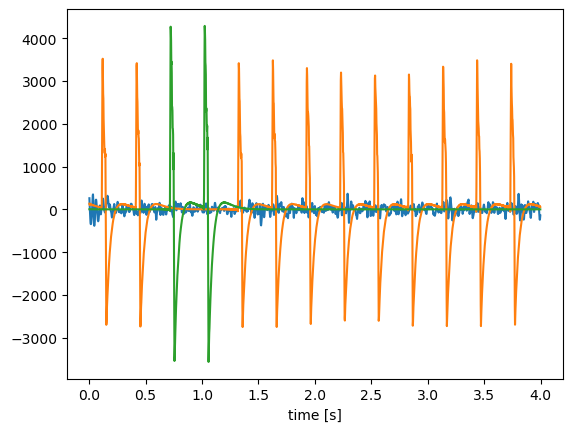

In [76]:
# plot the first 2000 samples 
# you shuld see the events (in this case oddball sounds)
# in green
t=np.arange(0, ld_int)*1/500
plt.figure('Data')
plt.plot(t[1:2000], data_new[1:2000])
plt.xlabel('time [s]')
#plt.xlim(0,max(t))

Text(0, 0.5, 'signal [mVolts]')

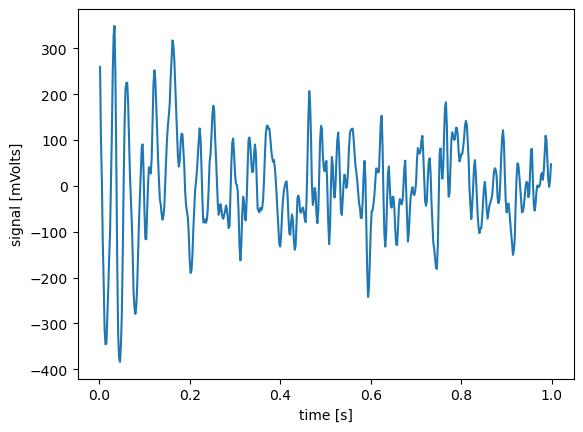

In [77]:
# plot the first 1 second of raw EEG data, just to know what it looks like
plt.figure('Data')
plt.plot(t[1:500], data_new[1:500,0])
plt.xlabel('time [s]')
plt.ylabel('signal [mVolts]')

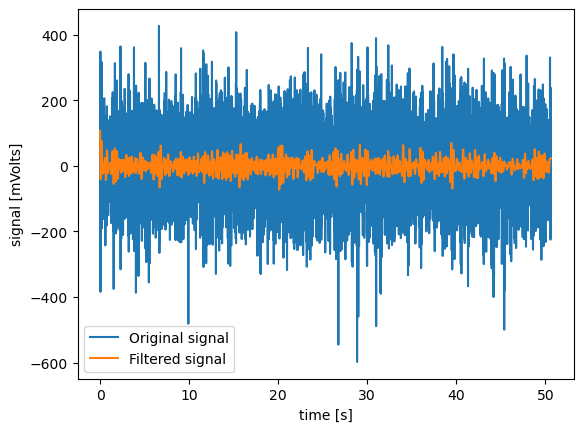

In [78]:
# lowpass-filter the raw signal
from scipy.signal import butter, filtfilt

# Define filter parameters
fc = 35 # Cutoff frequency (Hz)
order = 10 # Filter order

# define the signal variable
signal = data_new[:,0]

# Create the filter coefficients using a Butterworth filter
b, a = butter(order, fc/(fs/2), btype='low')

# Apply the filter using filtfilt to avoid phase distortion
filtered_signal = filtfilt(b, a, signal)

# plot the original and filtered signals
fig, ax = plt.subplots()
ax.plot(t, signal, label='Original signal')
ax.plot(t, filtered_signal, label='Filtered signal')
ax.legend()
plt.xlabel('time [s]')
plt.ylabel('signal [mVolts]')
plt.show()

Text(0, 0.5, 'signal [mVolts]')

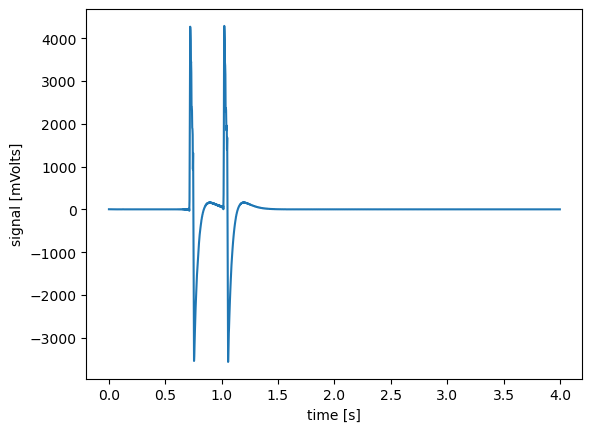

In [79]:
# identify the column of the array where the beeps are stored
beep_signal = data_new[0:ld_int,2]
plt.plot(t[1:2000], beep_signal[1:2000])
plt.xlabel('time [s]')
plt.ylabel('signal [mVolts]')

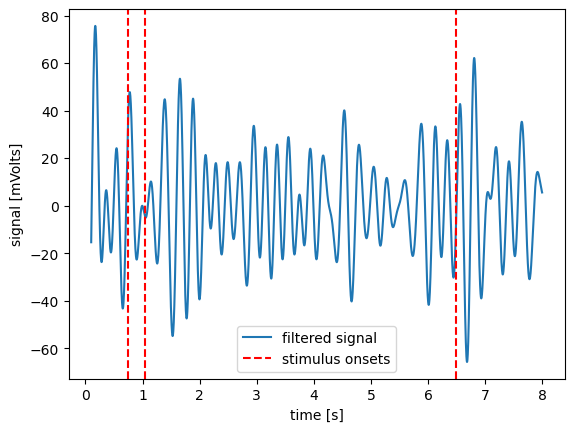

In [80]:
# find the indices of the beep events
event_indices = np.where(beep_signal > 1000)
event_indices = event_indices[0]
event_onset_indices = np.where(np.diff(event_indices) >10)
event_onset_indices = event_onset_indices[0]
final_event_indices = event_indices[event_onset_indices]

# plot indices together with the filtered data
fig, ax = plt.subplots()
ax.plot(t[50:4000], filtered_signal[50:4000], label='filtered signal')
ax.axvline(x=final_event_indices[0]/500, color='r', linestyle='--', label='stimulus onsets')
ax.axvline(x=final_event_indices[1]/500, color='r', linestyle='--')
ax.axvline(x=final_event_indices[2]/500, color='r', linestyle='--')
ax.legend()
plt.xlabel('time [s]')
plt.ylabel('signal [mVolts]')
plt.show()


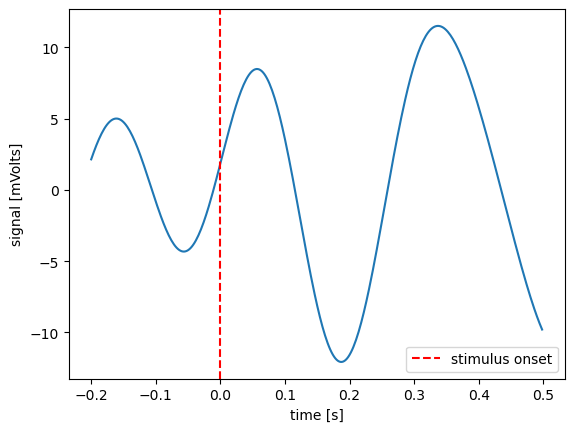

In [81]:
# now we have to do a time-locked average to produce an ERP
# define the time window in seconds around the event onset
window_seconds = np.array([-0.2, 0.5])
window_samples = 500*window_seconds
window_samples = np.round(window_seconds*500).astype(int)

# loop over events, stack them on top of each other
segments = []
for index in final_event_indices:
    segment_start = index + window_samples[0]
    segment_end = index + window_samples[1]
    segment = filtered_signal[segment_start:segment_end]
    segments.append(segment)

# average to get an ERP
erp = np.mean(segments,0)
erp_time = np.arange(window_samples[0]/500, window_samples[1]/500, 1/500)

# plot
fig, ax=plt.subplots()
ax.plot(erp_time, erp)
plt.xlabel('time [s]')
plt.ylabel('signal [mVolts]')
ax.axvline(x=0, color='r', linestyle='--', label='stimulus onset')
ax.legend()